# GameStats2Text: Main Training Notebook

This notebook implements the end-to-end pipeline for the GameStats2Text model:

1. Load and preprocess the dataset
2. Split into train/validation/test sets (75/20/5)
3. Set up PyTorch data loaders
4. Initialize model components
5. Train the model
6. Evaluate performance
7. Generate example outputs

In [1]:
# Import libraries
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from transformers import GPT2Tokenizer, get_linear_schedule_with_warmup
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import random
import json
from datetime import datetime

# Import project modules
from src.process.stats_encoder import StatsEncoder
from src.models.encoder import GameStats2TextModel
from src.models.generator import GameStats2TextGenerator
from src.process.setupData import GameStatsTextDataset, collate_fn

# Set seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

/opt/anaconda3/envs/nlp-proj/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


## 1. Load and Explore Dataset

In [2]:
# Load the dataset
data_path = 'data/dataset.csv'
df = pd.read_csv(data_path)

# Display basic info
print(f"Dataset shape: {df.shape}")
print("\nColumn names:")
print(df.columns.tolist())
print("\nSample data:")
df.head()

Dataset shape: (1193, 13)

Column names:
['date', 'MP', 'PTS', 'FG%', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'Result', 'question', 'answer']

Sample data:


,date,MP,PTS,FG%,TRB,AST,STL,BLK,TOV,PF,Result,question,answer
0,2007-05-21,45:22,10.0,0.333,10.0,9.0,4.0,1.0,2.0,1.0,0,"I know you say that you're a football player, ...",(Laughing) It was definitely a physical game t...
1,2007-05-21,45:22,10.0,0.333,10.0,9.0,4.0,1.0,2.0,1.0,0,"The last play there, Coach said that was kind ...","No, I go for the winning play. If two guys co..."
2,2007-05-21,45:22,10.0,0.333,10.0,9.0,4.0,1.0,2.0,1.0,0,"As a franchise player, how do you justify only...","No, you've just got to take what's there. It'..."
3,2007-05-21,45:22,10.0,0.333,10.0,9.0,4.0,1.0,2.0,1.0,0,Coach said that a couple of adjustments need t...,We definitely played pretty well. Both teams ...
4,2007-05-21,45:22,10.0,0.333,10.0,9.0,4.0,1.0,2.0,1.0,0,"Third quarter, again, you guys fell behind 7-0...",Not sure. It's just something that we've got ...


In [3]:
# Display statistical summary
print("Statistical summary of numeric columns:")
df.describe()

Statistical summary of numeric columns:


,PTS,FG%,TRB,AST,STL,BLK,TOV,PF,Result
count,1193.000000,1193.000000,1193.000000,1193.000000,1193.000000,1193.000000,1193.000000,1193.000000,1193.000000
mean,29.678122,0.499261,9.590947,7.499581,1.554065,0.953898,3.714166,2.433361,0.539816
std,8.878770,0.111476,3.377579,2.790842,1.191681,1.012698,1.956218,1.292386,0.498621
min,7.000000,0.200000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24.000000,0.429000,7.000000,5.000000,1.000000,0.000000,2.000000,2.000000,0.000000
50%,29.000000,0.500000,9.000000,8.000000,2.000000,1.000000,4.000000,2.000000,1.000000
75%,35.000000,0.588000,12.000000,9.000000,2.000000,2.000000,5.000000,3.000000,1.000000
max,51.000000,0.846000,18.000000,13.000000,5.000000,3.000000,8.000000,6.000000,1.000000


In [4]:
# Check for missing values
print("Missing values per column:")
df.isnull().sum()

Missing values per column:


date        0
MP          0
PTS         0
FG%         0
TRB         0
AST         0
STL         0
BLK         0
TOV         0
PF          0
Result      0
question    0
answer      0
dtype: int64

## 2. Data Preparation and Splitting

In [5]:
# Convert 'MP' (minutes played) from "MM:SS" to float minutes if needed
if 'MP' in df.columns and df['MP'].dtype == 'object':
    df['MP'] = df['MP'].apply(lambda x: float(str(x).split(':')[0]) + float(str(x).split(':')[1]) / 60.0 if ':' in str(x) else float(x))

# Make sure all feature columns are numeric
feature_cols = [c for c in df.columns if c not in ['date', 'question', 'answer']]
df[feature_cols] = df[feature_cols].apply(pd.to_numeric, errors='coerce')

# Drop rows with NaN values if any
if df.isnull().sum().sum() > 0:
    print(f"Dropping {df.isnull().any(axis=1).sum()} rows with NaN values")
    df = df.dropna()
    print(f"New dataset shape: {df.shape}")

In [6]:
# Create the full dataset
tokenizer_name = 'gpt2'
max_length = 256

full_dataset = GameStatsTextDataset(
    csv_file=data_path,
    tokenizer_name=tokenizer_name,
    max_length=max_length
)

# Get the tokenizer
tokenizer = GPT2Tokenizer.from_pretrained(tokenizer_name)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

/opt/anaconda3/envs/nlp-proj/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [7]:
# Get dataset size and calculate split sizes
dataset_size = len(full_dataset)
train_size = int(0.75 * dataset_size)
val_size = int(0.20 * dataset_size)
test_size = dataset_size - train_size - val_size

print(f"Total dataset size: {dataset_size}")
print(f"Training set size: {train_size}")
print(f"Validation set size: {val_size}")
print(f"Test set size: {test_size}")

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

Total dataset size: 1193
Training set size: 894
Validation set size: 238
Test set size: 61


In [8]:
# Create data loaders
batch_size = 16

train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    collate_fn=collate_fn,
    num_workers=2
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    collate_fn=collate_fn,
    num_workers=2
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    collate_fn=collate_fn,
    num_workers=2
)

In [9]:
# Check a batch from the training loader
sample_batch = next(iter(train_loader))
print("Sample batch shapes:")
for k, v in sample_batch.items():
    print(f"{k}: {v.shape}")

# Decode a sample to verify data is loaded correctly
sample_idx = 0
sample_question = tokenizer.decode(sample_batch['input_ids'][sample_idx], skip_special_tokens=True)
sample_answer = tokenizer.decode(sample_batch['labels'][sample_idx], skip_special_tokens=True)
print(f"\nSample question: {sample_question}")
print(f"Sample answer: {sample_answer}")
print(f"Sample stats: {sample_batch['stats'][sample_idx]}")

Sample batch shapes:
stats: torch.Size([16, 10])
input_ids: torch.Size([16, 256])
attention_mask: torch.Size([16, 256])
labels: torch.Size([16, 256])

Sample question: As far as Chris, we know he hurt his ankle the other night  He says it's been just not happening for him the entire series, and he's not sure why  Any thoughts on Chris?
Sample answer: I mean, we can state the obvious; they're both struggling  Chris is struggling with his shot, and him hurting his ankle didn't help him a lot as well  I think he will find it  He will find it  It's my job as a leader to keep him motivated, to let him know how important he is to our movement, to our chances of returning to The Finals. The best thing about this opportunity is right here we worked all season long to get home‑court advantage  If we ever had an opportunity or we put ourselves in position where we weren't taking care of business on the road, we always have one more to fall back on at home  This is the position we're in and those

## 3. Model Configuration

In [10]:
# Get stats input dimension from the dataset
stats_input_dim = full_dataset.stats.shape[1]
print(f"Stats input dimension: {stats_input_dim}")

# Model hyperparameters
stats_hidden_dims = [128, 64]
stats_output_dim = 32
gpt_model_name = 'gpt2'
fusion_method = 'concat'  # 'concat' or 'add'

Stats input dimension: 10


In [11]:
# Initialize the generator model
model = GameStats2TextGenerator(
    stats_input_dim=stats_input_dim,
    stats_hidden_dims=stats_hidden_dims,
    stats_output_dim=stats_output_dim,
    gpt_model_name=gpt_model_name,
    fusion_method=fusion_method
)

# Move model to device
model = model.to(device)

# Display model summary
print(model)
print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")

GameStats2TextGenerator(
  (stats_encoder): StatsEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=10, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=128, out_features=64, bias=True)
      (4): ReLU(inplace=True)
      (5): Dropout(p=0.1, inplace=False)
      (6): Linear(in_features=64, out_features=32, bias=True)
    )
  )
  (gpt2): GPT2LMHeadModel(
    (transformer): GPT2Model(
      (wte): Embedding(50257, 768)
      (wpe): Embedding(1024, 768)
      (drop): Dropout(p=0.1, inplace=False)
      (h): ModuleList(
        (0-11): 12 x GPT2Block(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): GPT2Attention(
            (c_attn): Conv1D(nf=2304, nx=768)
            (c_proj): Conv1D(nf=768, nx=768)
            (attn_dropout): Dropout(p=0.1, inplace=False)
            (resid_dropout): Dropout(p=0.1, inplace=False)
          )
          (ln_2): LayerNo

## 4. Training Configuration

In [12]:
# Training hyperparameters
num_epochs = 1
learning_rate = 5e-5
weight_decay = 0.01
warmup_steps = 100
max_grad_norm = 1.0

# Initialize optimizer
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Learning rate scheduler
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=warmup_steps, 
    num_training_steps=total_steps
)

## 5. Training Loop

In [13]:
# Training and validation functions
def train_epoch(model, dataloader, optimizer, scheduler, device):
    model.train()
    epoch_loss = 0

    from tqdm import tqdm as std_tqdm
    progress_bar = std_tqdm(dataloader, desc="Training")
    
    for batch in progress_bar:
        # Move batch to device
        stats = batch['stats'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # Replace padding token id with -100 so it's ignored in loss computation
        labels = torch.where(labels == tokenizer.pad_token_id, -100, labels)
        
        # Forward pass
        outputs = model(
            stats=stats,
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()
        
        # Update progress bar
        progress_bar.set_postfix({"loss": loss.item()})
        epoch_loss += loss.item()
        
    return epoch_loss / len(dataloader)

def evaluate(model, dataloader, device):
    model.eval()
    epoch_loss = 0
    
    # Use standard tqdm here too
    from tqdm import tqdm as std_tqdm
    
    with torch.no_grad():
        for batch in std_tqdm(dataloader, desc="Evaluating"):
            # Move batch to device
            stats = batch['stats'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # Replace padding token id with -100
            labels = torch.where(labels == tokenizer.pad_token_id, -100, labels)
            
            # Forward pass
            outputs = model(
                stats=stats,
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            epoch_loss += loss.item()
            
    return epoch_loss / len(dataloader)

In [ ]:
# Training loop
train_losses = []
val_losses = []

best_val_loss = float('inf')
best_model_path = 'best_model.pt'

print("Starting training...")
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    # Train
    train_loss = train_epoch(model, train_loader, optimizer, scheduler, device)
    train_losses.append(train_loss)
    
    # Validate
    val_loss = evaluate(model, val_loader, device)
    val_losses.append(val_loss)
    
    print(f"Train loss: {train_loss:.4f}, Validation loss: {val_loss:.4f}")
    
    Save best mode l
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Model saved to {best_model_path}")

Starting training...

Epoch 1/1


Evaluating: 100%|██████████| 15/15 [00:21<00:00,  1.46s/it]

Train loss: 6.6974, Validation loss: 6.0950


In [18]:

if val_loss < best_val_loss:
    best_val_loss = val_loss
    torch.save(model.state_dict(), best_model_path)
    print(f"Model saved to {best_model_path}")

Model saved to best_model.pt


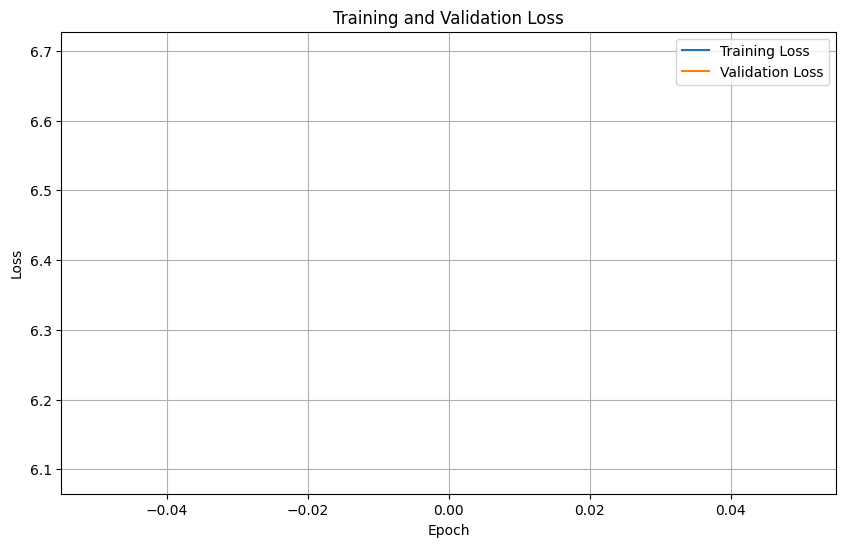

In [19]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

## 6. Test Set Evaluation

In [20]:
# Load best model for evaluation
model.load_state_dict(torch.load(best_model_path))

# Evaluate on test set
test_loss = evaluate(model, test_loader, device)
print(f"Test Loss: {test_loss:.4f}")

Evaluating: 100%|██████████| 4/4 [00:08<00:00,  2.06s/it]

Test Loss: 6.1580


## 7. Generate Example Responses

In [21]:
# Generate a few examples from the test set
num_examples = 3
test_samples = [test_dataset[i] for i in range(num_examples)]

model.eval()
for i, sample in enumerate(test_samples):
    # Get the input data
    stats = sample['stats'].unsqueeze(0).to(device)
    input_ids = sample['input_ids'].unsqueeze(0).to(device)
    attention_mask = sample['attention_mask'].unsqueeze(0).to(device)
    
    # Get the question
    question = tokenizer.decode(input_ids[0], skip_special_tokens=True)
    
    # Get the actual answer
    actual_answer = tokenizer.decode(sample['labels'], skip_special_tokens=True)
    
    # Generate a response
    generated_text = model.generate(
        stats=stats,
        prompt=question,
        tokenizer=tokenizer,
        max_length=150,
        num_beams=5,
        top_k=50,
        top_p=0.9
    )
    
    print(f"\nExample {i+1}:")
    print(f"Question: {question}")
    print(f"Actual answer: {actual_answer}")
    print(f"Generated answer: {generated_text}")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Example 1:
Question: Are you tired?  You feel like you can --
Actual answer: I'm everything, I'm banged up, I'm winded, I'm fatigued.  I've got all day tomorrow.  It's going to be tough to get some rest when you got a crazy two-year-old running around the house.  So hopefully I can take him to one of his grandma's house.
Generated answer:  and I   I have to be a good team, I'm not going to be able to be the best in the game. That's what I'm going to do.


"I don't think we're going to have a lot of things to do, and I think we've got to be better. We've got a lot to do and I'm just going to try to do the best I can do. It's going to take a little bit of time to get better. I don't know what to do in the second half of the game, but I think that's what we're trying to do as a team. I just have to make sure we


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Example 2:
Question: In terms of style play, do you have to be mindful of whether it's running into a guy, whether you're going up for a foul, hard foul?
Actual answer: Well, you just play the game the right way  At this point, you try to do whatever it takes to win  You don't want to hurt nobody  No one, I think, in our league goes around trying to hurt people, but you don't take the aggressive nature out of the game. I think in the case of‑‑ ever since you were a kid, the ball on the floor, the first man to the floor usually gets the ball  There's no difference between what Delly did to Kyle Korver last game and 18 guys diving on the floor late in the game tonight  It was like six or seven guys diving on the floor for that loose ball  Delly was on the floor  J.J. was on the floor  Mike Scott was on the floor  Shump was on the floor  J.R. was on the floor  Just no one got hurt. There's no difference between me boxing out or Al Horford boxing me out and Delly boxing someone out  That 

## 8. Save Model and Metadata

In [ ]:
# Create a folder for the final model
output_dir = 'output'
os.makedirs(output_dir, exist_ok=True)

# Save the model
model_path = os.path.join(output_dir, 'final_model.pt')
torch.save(model.state_dict(), model_path)

# Save the config
config = {
    'stats_input_dim': stats_input_dim,
    'stats_hidden_dims': stats_hidden_dims,
    'stats_output_dim': stats_output_dim,
    'gpt_model_name': gpt_model_name,
    'fusion_method': fusion_method,
    'tokenizer_name': tokenizer_name,
    'max_length': max_length,
    'training_date': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    'final_train_loss': train_losses[-1],
    'final_val_loss': val_losses[-1],
    'test_loss': test_loss
}

with open(os.path.join(output_dir, 'model_config.json'), 'w') as f:
    json.dump(config, f, indent=4)

print(f"Model saved to {model_path}")
print(f"Config saved to {os.path.join(output_dir, 'model_config.json')}")

## 9. Inference Function for New Data

In [ ]:
def generate_response(model, stats, question, tokenizer):
    """
    Generate a response for a new game stats and question pair.
    
    Args:
        model: The trained GameStats2TextGenerator model
        stats: A list or numpy array of game statistics (matching the input dimensions)
        question: The question to ask about the game
        tokenizer: The GPT2 tokenizer
    
    Returns:
        str: The generated response
    """
    # Convert stats to tensor if needed
    if not isinstance(stats, torch.Tensor):
        stats = torch.tensor(stats, dtype=torch.float32)
    
    # Add batch dimension if needed
    if stats.dim() == 1:
        stats = stats.unsqueeze(0)
    
    # Move to device
    stats = stats.to(device)
    
    # Generate text
    model.eval()
    with torch.no_grad():
        response = model.generate(
            stats=stats,
            prompt=question,
            tokenizer=tokenizer,
            max_length=150,
            num_beams=5,
            top_k=50,
            top_p=0.9
        )
    
    return response

## 10. Conclusion

This notebook demonstrated the full pipeline for training and evaluating a GameStats2Text model that fuses basketball game statistics with text generation. The model learns to generate player-specific responses to questions about game performance.

Next steps could include:

1. Fine-tuning hyperparameters for better performance
2. Experimenting with different model architectures
3. Adding style conditioning to better capture player-specific language
4. Implementing evaluation metrics like BERTScore or human evaluation